<a href="https://colab.research.google.com/github/Nishr27/CANN/blob/main/CANN_for_Mooney_Rivlin_material.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Training and Test Data for CANN

We start by preparing data according to the Mooney-Rivlin model using the following equation, for generating the strain energy function:

- psi = ci0*(I - 3)**i + c0i*(II - 3)**i
we have the material parameters given as per the Table 1 in the research paper Linka et al.

We write the functions that are used throughout the program. 

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn.preprocessing as StandardScaler

In [ ]:
def deformation_gradient(batch_size):
  """
  Returns the Deformation Gradients generated for three types of loading: Uniaxial Tension Loading, Equi-Biaxial Loading and Pure Shear Loading

  """
  # Generating random stretch values between 1 to 7
  #stretch = tf.random.uniform(shape=[batch_size], minval=1, maxval=7, dtype=tf.float32, seed=42)
  stretch = tf.Variable(np.linspace(1.2, 7.0, num=batch_size, endpoint=True, dtype=np.float32))
  sqrt_stretch = tf.math.sqrt(stretch)
  stretch_sqr = tf.math.square(stretch)

  # Deformation Gradient for Uniform Tension Loading
  uniform_tension = tf.Variable(tf.zeros(shape=[batch_size, 3, 3]))
  for i in range(0, batch_size):
    uniform_tension[i, 0, 0].assign(stretch[i])
    uniform_tension[i, 1, 1].assign(1/sqrt_stretch[i])
    uniform_tension[i, 2, 2].assign(1/sqrt_stretch[i])
  
  # Deformation Gradient for Equi-Biaxial Loading
  eq_biaxial = tf.Variable(tf.zeros(shape=[batch_size, 3, 3]))
  for i in range(0, batch_size):
    eq_biaxial[i, 0, 0].assign(stretch[i])
    eq_biaxial[i, 1, 1].assign(stretch[i])
    eq_biaxial[i, 2, 2].assign(1/stretch_sqr[i])
  
  # Deformation Gradient for Pure Shear Loading
  pure_shear = tf.Variable(tf.eye(3, batch_shape=[batch_size], dtype=tf.float32))
  for i in range(0, batch_size):
    pure_shear[i, 0, 0].assign(stretch[i])
    pure_shear[i, 1, 1].assign(1/stretch[i])
  
  return uniform_tension, eq_biaxial, pure_shear, stretch  

In [ ]:
def strain_energy(first_inv, second_inv):
  """ 
  This function provides the strain energy function based on the Mooney-Rivlin rule, given the first and second strain invariants (Ic and IIc).
  We also define the material constants ci0 and c0i here.
  This can then be used for training the CANN using the invariants as inputs and the energy function as the label for a certain pair of invariants.

  """
  # Material Constants
  ci0 = tf.constant([1.6e-1, -1.4e-3, 3.9e-5])
  c0i = tf.constant([1.5e-2, -2.0e-6, 1.0e-10])
  
  # Getting the batch size for the data
  batch_size = first_inv.shape[0]

  # Initializing the psi function with zeros
  psi = tf.Variable(tf.zeros(batch_size))

  # Calculation of strain energy function
  for i in range(0, batch_size):
    sum = 0
    
    for j in range(0, 3):
      sum = sum + ci0[j] * ((first_inv[i] - 3)**(j+1)) + c0i[j] * ((second_inv[i] - 3)**(j+1))

    psi[i].assign(sum)

  # Return the calculated energy function
  return psi

In [ ]:
def right_Cauchy_Green_tensor(def_gradient):
  """
  Function formulates the right Cauchy-Green Tensor from the Deformation Gradient
  
  """
  # Right Cauchy-Green Tensor C from Deformation Gradient
  C = tf.linalg.matmul(def_gradient, def_gradient, transpose_a=True)

  return C

In [ ]:
def strain_invariants(C):
  """ 
  This function calculates the strain/stress invariants given the right Cauchy-Green Tensor.
  
  """
  # First Strain Invariant
  first_inv = tf.linalg.trace(C)

  # Second Strain Invariant
  second_inv = 0.5*((tf.math.square(first_inv)) - tf.linalg.trace(tf.linalg.matmul(C, C, transpose_a=True)))

  return first_inv, second_inv  

In [ ]:
def second_Piola_Kirchhoff_stress(psi, C):
  """
  This function calculate the second Piola-Kirchhoff stress by taking the Gradient of the strain energy w.r.t right Cauchy Green Tensor
  
  """
  with tf.GradientTape() as tape:
    tape.watch(C)
    I = tf.linalg.trace(C)
    II = 0.5*( (tf.linalg.trace(C)**2) - (tf.linalg.trace(tf.linalg.matmul(C, C, transpose_a=True))) )
    psi = 1.6e-1*(I - 3) + 1.5e-2*(II - 3) + (-1.4e-3)*((I - 3)**2) + (-2.0e-6)*((II - 3)**2) + (3.9e-5)*((I - 3)**3) + (1.0e-10)*((II - 3)**3)

  return 2*tape.gradient(psi, C)

In [ ]:
def first_Piola_Kirchhoff_stress(S, def_grad):
  """
  This function returns the first Piola-Kirchhoff (nominal) stress by multiplying the Deformation Gradient and the second Piola-Kirchhoff stress
  """
  return tf.linalg.matmul(def_grad, S)

In [ ]:
def standard_scaling(first_inv, second_inv):
  from sklearn.preprocessing import StandardScaler

  scaler = StandardScaler()
  first_inv_scaled = scaler.fit_transform(first_inv)
  second_inv_scaled = scaler.transform(second_inv)

  return first_inv_scaled, second_inv_scaled

In [ ]:
def split_train_test(first_inv, second_inv, psi):
  """ 
  Splitting the Strain invariant data into Training and Test Sets with a Test size of 0.2
  """
  np.random.seed(42)
  shuffled_indices = np.random.permutation(first_inv.shape[0])
  test_set_size = int(first_inv.shape[0] * 0.2)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  return tf.gather(first_inv, train_indices), tf.gather(first_inv, test_indices), tf.gather(second_inv, train_indices), tf.gather(second_inv, test_indices), tf.gather(psi, train_indices), tf.gather(psi, test_indices)

In [ ]:
def CANN_model():
  """
  ANN Model 
  
  """  
  I = keras.layers.Input(shape=[1], name="I")
  II = keras.layers.Input(shape=[1],name="II")
  concat = keras.layers.concatenate([I, II])
  hidden0 = keras.layers.Dense(10, activation="relu")(concat)
  Psi = keras.layers.Dense(1, activation="relu", name="Psi")(hidden0)

  model = keras.models.Model(inputs=[I, II], outputs=[Psi])
  
  return model

#Body of the Main Function

**Generating the Deformation gradient values for the three load cases**

In [ ]:
# Setting the random seed
tf.random.set_seed(42)

# Generating deformation gradients for the various load cases: Uniaxial Tension (UT), Equi-biaxial Tension (EBT) and Pure Shear (PS)
# Also returning the stretches 
UT, EBT, PS, stretch = deformation_gradient(15)

# Checking the examples generated
print("Examples of the Deformation Gradients generated are: \n\n UT = ", UT[0], "\n\n EBT = ", EBT[0], "\n\n PS = ", PS[0], "\n\n Stretch = ", stretch)

Examples of the Deformation Gradients generated are: 

 UT =  tf.Tensor(
[[1.2       0.        0.       ]
 [0.        0.9128709 0.       ]
 [0.        0.        0.9128709]], shape=(3, 3), dtype=float32) 

 EBT =  tf.Tensor(
[[1.2       0.        0.       ]
 [0.        1.2       0.       ]
 [0.        0.        0.6944444]], shape=(3, 3), dtype=float32) 

 PS =  tf.Tensor(
[[1.2       0.        0.       ]
 [0.        0.8333333 0.       ]
 [0.        0.        1.       ]], shape=(3, 3), dtype=float32) 

 Stretch =  <tf.Variable 'Variable:0' shape=(15,) dtype=float32, numpy=
array([1.2      , 1.6142857, 2.0285714, 2.442857 , 2.857143 , 3.2714286,
       3.6857142, 4.1      , 4.5142856, 4.928571 , 5.3428574, 5.757143 ,
       6.1714287, 6.5857143, 7.       ], dtype=float32)>


**Calculating the strain invariants from the generated deformation gradients**

In [ ]:
# Right Cauchy-Green Tensor from the Deformation Gradient
C_ut = right_Cauchy_Green_tensor(UT)
C_ebt = right_Cauchy_Green_tensor(EBT)
C_ps = right_Cauchy_Green_tensor(PS)

print("Right Cauchy Green Tensors: \n\n UT = ", C_ut[0], "\n\n EBT = ", C_ebt[0], "\n\n PS = ", C_ps[0])

Right Cauchy Green Tensors: 

 UT =  tf.Tensor(
[[1.44       0.         0.        ]
 [0.         0.83333325 0.        ]
 [0.         0.         0.83333325]], shape=(3, 3), dtype=float32) 

 EBT =  tf.Tensor(
[[1.44       0.         0.        ]
 [0.         1.44       0.        ]
 [0.         0.         0.48225304]], shape=(3, 3), dtype=float32) 

 PS =  tf.Tensor(
[[1.44      0.        0.       ]
 [0.        0.6944444 0.       ]
 [0.        0.        1.       ]], shape=(3, 3), dtype=float32)


In [ ]:
# Strain Invariants for the three cases
I_ut, II_ut = strain_invariants(C_ut) 
I_ebt, II_ebt = strain_invariants(C_ebt)
I_ps, II_ps = strain_invariants(C_ps)

# Examples of the strain invariants 
print("Strain Invariants for Uniaxial Tension: \n\n First Invariant = ", I_ut, "\n\n Second Invariant = ", II_ut, "\n\n")
print("Strain Invariants for Equi-Biaxial Tension: \n\n First Invariant = ", I_ebt, "\n\n Second Invariant = ", II_ebt, "\n\n")
print("Strain Invariants for Pure Shear: \n\n First Invariant = ", I_ps, "\n\n Second Invariant = ", II_ps, "\n\n")

Strain Invariants for Uniaxial Tension: 

 First Invariant =  tf.Tensor(
[ 3.1066666  3.8448563  5.101017   6.7862635  8.863266  11.313599
 14.127125  17.297804  20.821814  24.69661   28.920458  33.492092
 38.410606  43.67532   49.285713 ], shape=(15,), dtype=float32) 

 Second Invariant =  tf.Tensor(
[ 3.094444   3.6123128  4.300148   5.0532856  5.836796   6.636299
  7.445038   8.259491   9.077652   9.898315  10.720764  11.544556
 12.36908   13.194519  14.020264 ], shape=(15,), dtype=float32) 


Strain Invariants for Equi-Biaxial Tension: 

 First Invariant =  tf.Tensor(
[ 3.3622532  5.3590946  8.289256  11.9631815 16.341537  21.41322
 27.174398  33.62354   40.759956  48.58332   57.09348   66.2903
 76.17375   86.7438    98.00042  ], shape=(15,), dtype=float32) 

 Second Invariant =  tf.Tensor(
[   3.4624894    7.5582943   17.420078    35.946804    66.8839
  114.72491    184.6856     282.6951     415.39255    590.1259
  814.95135   1098.6311    1450.6362    1881.1448    2401.041    ], 

**Calculating the Strain Energy Function from the Strain Invariants**

In [ ]:
# Strain Invariants for the three cases
psi_ut = strain_energy(I_ut, II_ut)
psi_ebt = strain_energy(I_ebt, II_ebt)
psi_ps = strain_energy(I_ps, II_ps)

print("Strain Energy Functions for UT, EBT and PS are: \n\n UT = ", psi_ut[0], "\n\n EBT = ", psi_ebt[0], "\n\n PS = ", psi_ps[0])

Strain Energy Functions for UT, EBT and PS are: 

 UT =  tf.Tensor(0.01846741, shape=(), dtype=float32) 

 EBT =  tf.Tensor(0.064715564, shape=(), dtype=float32) 

 PS =  tf.Tensor(0.02350254, shape=(), dtype=float32)


# Neural Network Model

**Preparing Training and Test sets**

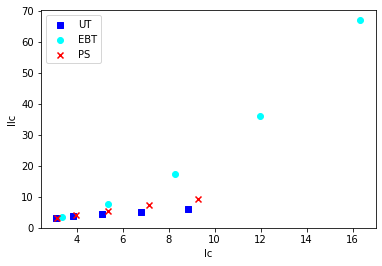

In [ ]:
# Plotting the Invariant plane (I-II plane)
plt.scatter(I_ut[:5], II_ut[:5], color="blue", marker="s", label="UT")
plt.scatter(I_ebt[:5], II_ebt[:5], color="cyan", marker="o", label="EBT")
plt.scatter(I_ps[:5], II_ps[:5], color="red", marker="x", label="PS")
plt.xlabel("Ic")
plt.ylabel("IIc")
plt.legend()
plt.show()

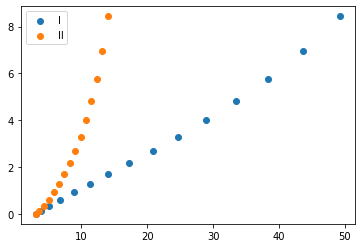

In [ ]:
plt.scatter(I_ut, psi_ut, label="I")
plt.scatter(II_ut, psi_ut, label="II")
plt.legend()

In [ ]:
I_ut_scaled, II_ut_scaled = standard_scaling(I_ut.numpy().reshape(-1,1), II_ut.numpy().reshape(-1,1))

I_ebt_scaled, II_ebt_scaled = standard_scaling(I_ebt.numpy().reshape(-1,1), II_ebt.numpy().reshape(-1,1))

I_ps_scaled, II_ps_scaled = standard_scaling(I_ps.numpy().reshape(-1, 1), II_ps.numpy().reshape(-1,1))

In [ ]:
I_ut_train, I_ut_test, II_ut_train, II_ut_test, psi_ut_train, psi_ut_test = split_train_test(I_ut_scaled, II_ut_scaled, psi_ut)

I_ebt_train, I_ebt_test, II_ebt_train, II_ebt_test, psi_ebt_train, psi_ebt_test = split_train_test(I_ebt, II_ebt, psi_ebt)

I_ps_train, I_ps_test, II_ps_train, II_ps_test, psi_ps_train, psi_ps_test = split_train_test(I_ps, II_ps, psi_ps)

**Building the Neural Network Model**

In [ ]:
model = CANN_model()

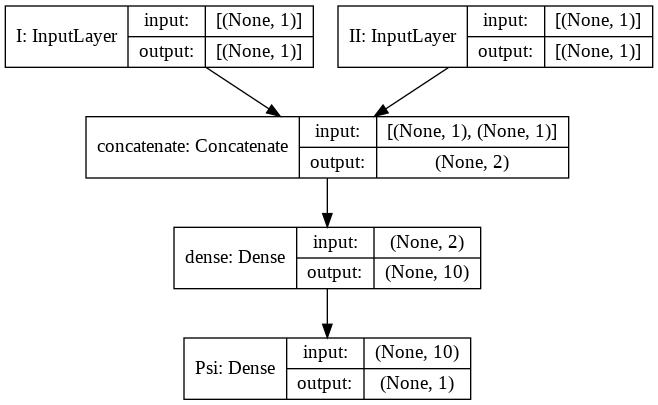

In [ ]:
# Checking the construction of the Neural Network
# Activation functions used in all layers are "ReLU"
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compiling the Model
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
I_all = tf.concat([I_ut, I_ebt], axis=0)
print(I_ut_test)
print(I_ebt_test)
I = tf.reshape(I_ut_test, (3,))
print(I)

tf.Tensor(
[[ 0.27624863]
 [ 0.87661994]
 [-1.1974604 ]], shape=(3, 1), dtype=float32)
tf.Tensor([48.58332   66.2903     3.3622532], shape=(3,), dtype=float32)
tf.Tensor([ 0.27624863  0.87661994 -1.1974604 ], shape=(3,), dtype=float32)


In [ ]:
# Training the Model on the prepared data
history1 = model.fit([I_ut_train, II_ut_train], psi_ut_train, epochs=1000, validation_data=([I_ut_test, II_ut_test], psi_ut_test))

history2 = model.fit([I_ebt_train, II_ebt_train], psi_ebt_train, epochs=1000, validation_data=([I_ebt_test, II_ebt_test], psi_ebt_test))

history3 = model.fit([I_ps_train, II_ps_train], psi_ps_train, epochs=1000, validation_data=([I_ps_test, II_ps_test], psi_ps_test))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step - loss: 0.0801 - val_loss: 0.1402
Epoch 502/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0798 - val_loss: 0.1404
Epoch 503/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0795 - val_loss: 0.1406
Epoch 504/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0792 - val_loss: 0.1409
Epoch 505/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.0789 - val_loss: 0.1411
Epoch 506/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0786 - val_loss: 0.1414
Epoch 507/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.0783 - val_loss: 0.1416
Epoch 508/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0781 - val_loss: 0.1419
Epoch 509/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0778 - val_loss: 0.1421
Epoch 510/1000
1/1 [==============================] - 0

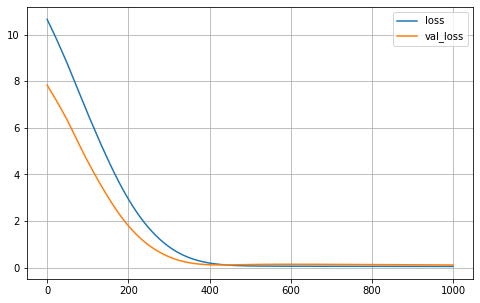

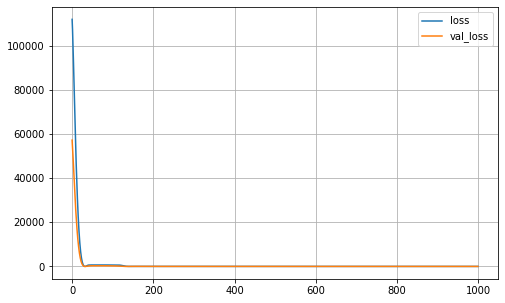

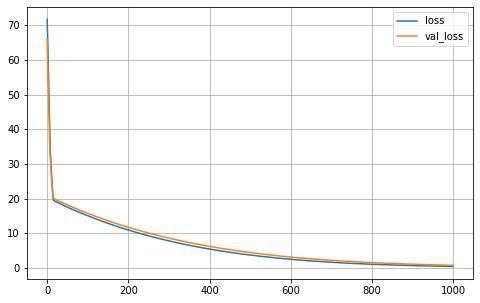

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
# Predicting the strain energy outputs for the I, II inputs
results = model.predict([I_ut, II_ut])

#Getting the Stress Values from the Strain Energy Function

In [ ]:
# Return the Second Piola Kirchhoff Stress
batch_size = C_ut.shape[0]
S_ut = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ebt = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ps = tf.Variable(tf.zeros([batch_size, 3, 3]))

for i in range(0, batch_size):
  S_ut[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ut[i], C_ut[i,:,:]))
  S_ebt[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt[i], C_ebt[i,:,:]))
  S_ps[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt[i], C_ebt[i,:,:]))

In [ ]:
# First Piola-Kirchhoff Stress
P_ut = first_Piola_Kirchhoff_stress(S_ut, UT)
P_ebt = first_Piola_Kirchhoff_stress(S_ebt, EBT)
P_ps = first_Piola_Kirchhoff_stress(S_ps, PS)

In [ ]:
# Getting the values for P11
P11_ut = P_ut[:,0,0]
P11_ebt = P_ebt[:,0,0]
P11_ps = P_ps[:,0,0]
print(P11_ut)
print(P11_ebt)
print(P11_ps)

tf.Tensor(
[0.44328484 0.56919366 0.6873499  0.79808    0.9034123  1.007403
 1.1164768  1.2397656  1.3894515  1.5811071  1.8340418  2.171641
 2.6217077  3.2168105  3.994622  ], shape=(15,), dtype=float32)
tf.Tensor(
[ 0.45079508  0.63051784  0.8553881   1.1405649   1.5089347   1.989221
  2.6153347   3.4256632   4.462188    5.7696085   7.3948627   9.387696
 11.8033     14.708329   18.192352  ], shape=(15,), dtype=float32)
tf.Tensor(
[ 0.45079508  0.63051784  0.8553881   1.1405649   1.5089347   1.989221
  2.6153347   3.4256632   4.462188    5.7696085   7.3948627   9.387696
 11.8033     14.708329   18.192352  ], shape=(15,), dtype=float32)


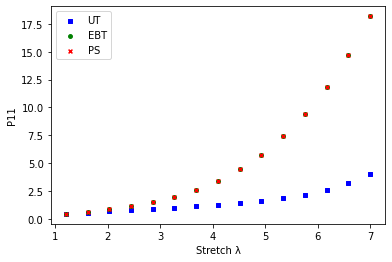

In [ ]:
# Plot P11 vs Stretch for all three types of deformations
plt.scatter(stretch, P11_ut, s=15, color="blue", marker="s", label="UT")
plt.scatter(stretch, P11_ebt, s=15, color="green", marker="o", label="EBT")
plt.scatter(stretch, P11_ps, s=15, color="red", marker="x", label="PS")
plt.xlabel("Stretch λ")
plt.ylabel("P11")
plt.legend()
plt.show()

# EBT and PS are almost coinciding in their plots so only one can be seen

**Predicted Stress Values by Model**

In [ ]:
#Predicting the Stress Values on the entire DataSet

psi_ut_pred = model.predict([I_ut_scaled, II_ut_scaled]).reshape(batch_size)
psi_ebt_pred = model.predict([I_ebt_scaled, II_ebt_scaled]).reshape(batch_size)
psi_ps_pred = model.predict([I_ps_scaled, II_ps_scaled]).reshape(batch_size)
print(psi_ut_pred)

[0.19549054 0.2226612  0.29936022 0.42369992 0.60173875 0.8321647
 1.114588   1.4486928  1.8342452  2.2710657  2.7968857  3.4582026
 4.0352783  4.5428104  5.0931973 ]


In [ ]:
# Getting the stress values for the predicted strain energy values
# Return the Second Piola Kirchhoff Stress
batch_size = C_ut.shape[0]
S_ut_pred = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ebt_pred = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ps_pred = tf.Variable(tf.zeros([batch_size, 3, 3]))

for i in range(0, batch_size):
  S_ut_pred[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ut_pred[i], C_ut[i,:,:]))
  S_ebt_pred[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt_pred[i], C_ebt[i,:,:]))
  S_ps_pred[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt_pred[i], C_ebt[i,:,:]))

In [ ]:
# Getting the First Piola-Kirchhoff Stress for predicted strain energy values
P_ut_pred = first_Piola_Kirchhoff_stress(S_ut_pred, UT)
P_ebt_pred = first_Piola_Kirchhoff_stress(S_ebt_pred, EBT)
P_ps_pred = first_Piola_Kirchhoff_stress(S_ps_pred, PS)

In [ ]:
# Getting the values for P11 for generated strain energy values
P11_ut_pred = P_ut_pred[:,0,0]
P11_ebt_pred = P_ebt_pred[:,0,0]
P11_ps_pred = P_ps_pred[:,0,0]
print(P11_ut_pred)
print(P11_ebt_pred)
print(P11_ps_pred)

tf.Tensor(
[0.44328484 0.56919366 0.6873499  0.79808    0.9034123  1.007403
 1.1164768  1.2397656  1.3894515  1.5811071  1.8340418  2.171641
 2.6217077  3.2168105  3.994622  ], shape=(15,), dtype=float32)
tf.Tensor(
[ 0.45079508  0.63051784  0.8553881   1.1405649   1.5089347   1.989221
  2.6153347   3.4256632   4.462188    5.7696085   7.3948627   9.387696
 11.8033     14.708329   18.192352  ], shape=(15,), dtype=float32)
tf.Tensor(
[ 0.45079508  0.63051784  0.8553881   1.1405649   1.5089347   1.989221
  2.6153347   3.4256632   4.462188    5.7696085   7.3948627   9.387696
 11.8033     14.708329   18.192352  ], shape=(15,), dtype=float32)


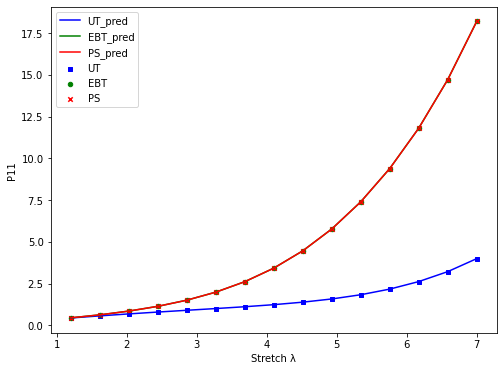

In [ ]:
# Plot P11 vs Stretch for all three types of deformations
plt.figure(figsize=(8, 6))
plt.plot(stretch.numpy(), P11_ut_pred.numpy(), color="blue", linestyle="solid", label="UT_pred")
plt.plot(stretch.numpy(), P11_ebt_pred.numpy(), color="green", linestyle="solid", label="EBT_pred")
plt.plot(stretch.numpy(), P11_ps_pred.numpy(), color="red", linestyle="solid", label="PS_pred")

# The previous Graph showing actual values
# Plot P11 vs Stretch for all three types of deformations
plt.scatter(stretch, P11_ut, s=20, color="blue", marker="s", label="UT")
plt.scatter(stretch, P11_ebt, s=20, color="green", marker="o", label="EBT")
plt.scatter(stretch, P11_ps, s=20, color="red", marker="x", label="PS")
plt.xlabel("Stretch λ")
plt.ylabel("P11")
plt.legend()
plt.show()